针对路透社的数据集，进行单标签多分类。输入数据与imdb一样，是word的index，label是0~45，对应不同的主题

## Data preparation

In [7]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
print("train_data sample num: ", len(train_data))
print("test_data sample num: ", len(test_data))
print("train label shape is: ", train_labels.shape)

train_data sample num:  8982
test_data sample num:  2246
train label shape is:  (8982,)


In [2]:
print("data format is")
print(train_data[0])

data format is
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [5]:
word_dict = reuters.get_word_index()
reverse_word_dict = dict([(value, key) for (key, value) in word_dict.items()])
decoded_review = ' '.join(reverse_word_dict.get(i-3, '?') for i in train_data[0])
print("Decoded comment for train_data[0] with label ", train_labels[0], " is \n", decoded_review)

Decoded comment for train_data[0] with label  3  is 
 ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [8]:
import numpy as np
# convert sequences into one-hot format
def vectorize_sequences(sequences, dimension=10000):
    result = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        result[i,sequence] = 1.
    return result

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

- 这里label是多分类，因此需要将label做one-hot表示

In [9]:
def to_one_hot(labels, dimension=46):
    result = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        result[i, label] = 1
    return result
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [11]:
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Model build

In [12]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### split validataion set and do validate

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [16]:
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 268us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 163us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 168us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 171us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 170us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 164us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 172us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


### draw train history

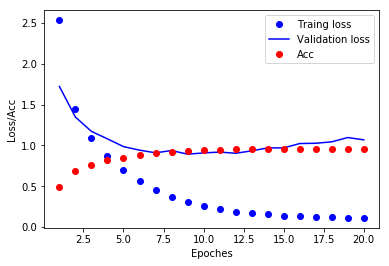

In [19]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
validation_loss_values = history_dict['val_loss']
epoches = range(1, len(validation_loss_values) + 1)
acc = history_dict['acc']
plt.plot(epoches, loss_values, 'bo', label='Traing loss')
plt.plot(epoches, validation_loss_values, 'b', label = 'Validation loss')
plt.plot(epoches, acc, 'ro', label = 'Acc')
plt.xlabel('Epoches')
plt.ylabel('Loss/Acc')
plt.legend()
plt.show()

- 从图上看第10轮开始validation set上loss开始上升，所以选择epchs=10

### do train and test

In [21]:
model.fit(x_train, one_hot_train_labels,
          epochs=10,
          batch_size=512)

Epoch 1/10
8982/8982 [==============================] - 2s 192us/step - loss: 0.2079 - acc: 0.9428
Epoch 2/10
8982/8982 [==============================] - 1s 158us/step - loss: 0.1677 - acc: 0.9470
Epoch 3/10
8982/8982 [==============================] - 1s 154us/step - loss: 0.1477 - acc: 0.9500
Epoch 4/10
8982/8982 [==============================] - 1s 153us/step - loss: 0.1352 - acc: 0.9525
Epoch 5/10
8982/8982 [==============================] - 1s 158us/step - loss: 0.1271 - acc: 0.9534
Epoch 6/10
8982/8982 [==============================] - 1s 157us/step - loss: 0.1226 - acc: 0.9544
Epoch 7/10
8982/8982 [==============================] - 1s 156us/step - loss: 0.1146 - acc: 0.9547
Epoch 8/10
8982/8982 [==============================] - 1s 147us/step - loss: 0.1136 - acc: 0.9547
Epoch 9/10
8982/8982 [==============================] - 1s 152us/step - loss: 0.1124 - acc: 0.9550
Epoch 10/10
8982/8982 [==============================] - 1s 153us/step - loss: 0.1125 - acc: 0.9557


In [22]:
result = model.evaluate(x_test, one_hot_test_labels)
print(result)

2246/2246 [==============================] - 0s 210us/step
[1.255591887612483, 0.7871772039711529]


In [28]:
predictions = model.predict(x_test)
# print best predict
print("for test[0], predict result is ", np.argmax(predictions[0]), 
      " with prob ", predictions[0][np.argmax(predictions[0])])

for test[0], predict result is  3  with prob  0.9830778


- 通过np.argmax来查找最大的可能类别